In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn import metrics
from collections import Counter
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import model_selection

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see model hyperparameters
from sklearn import set_config
set_config(print_changed_only = False)

# to show all columns
pd.set_option('display.max_columns', 15)

# Supervised Machine Learning: Final Project



### Problem
Want to be able to predict the pricing of used car sales
- Similar to housing price prediction problem discussed in class
- Predicting sales price of used cars would allow for the seller to appropriately price their own car when selling
- Also, used car dealers would be able to make the highest profit of resales

Dataset taken from CarDekho: a used car seller in India
- Shared on kaggle via the following: 
    - https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv
- Data is from India, so sales pricing is in Rupees

### Process
- Exploratory Data Analysis
- Modeling using single-/multi-variable linear regression
- Discussion of results
- Conclusion

In [2]:
fpath = r"https://raw.githubusercontent.com/wmTemp/MSDS_UnsupervisedMachineLearning/refs/heads/main/Car%20details%20v3.csv"
car = pd.read_csv(fpath)

### Exploratory Data 

Initially, want to see what is contained in the overall dataset, including the data types and variables

In [3]:
df = car.copy()
df.head().style.background_gradient(cmap = "Reds")

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.000000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.000000
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.000000
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.000000
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
print("The raw dataset has {0} rows and {1} columns".
      format(df.shape[0], df.shape[1]))

The raw dataset has 8128 rows and 13 columns


### Add in additional variables for context and reformat existing variables

Add in variables for brand name and care age, as well as extract the numeric data from the engine, mileage, and max_power variables

In [19]:
categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

# extract brand name from car name

df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")

# extract engine and mileage values as numeric variables

df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")

# extract max_power values as numeric variable

df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")

# extract car age from year
df["car_age"] = (datetime.datetime.now().year) - (df["year"])
df.drop(["name", "year", "torque"], axis = 1, inplace = True)

KeyError: 'name'

In [7]:
df.head().style.background_gradient(cmap = "Reds")

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.400000,1248.000000,74.000000,5.000000,Maruti,11
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.140000,1498.000000,103.520000,5.000000,Skoda,11
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.700000,1497.000000,78.000000,5.000000,Honda,19
3,225000,127000,Diesel,Individual,Manual,First Owner,23.000000,1396.000000,90.000000,5.000000,Hyundai,15
4,130000,120000,Petrol,Individual,Manual,First Owner,16.100000,1298.000000,88.200000,5.000000,Maruti,18


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


### Fill in missing values

Locate and deal with missing values

In [9]:
# determine the number of missing/null values for each variable
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [10]:
# describe dataset
df.describe().T.style.background_gradient(cmap = "Reds")

,count,mean,std,min,25%,50%,75%,max
selling_price,8128.000000,638271.807702,806253.403508,29999.000000,254999.000000,450000.000000,675000.000000,10000000.000000
km_driven,8128.000000,69819.510827,56550.554958,1.000000,35000.000000,60000.000000,98000.000000,2360457.000000
mileage,7907.000000,19.418783,4.037145,0.000000,16.780000,19.300000,22.320000,42.000000
engine,7907.000000,1458.625016,503.916303,624.000000,1197.000000,1248.000000,1582.000000,3604.000000
max_power,7912.000000,91.517919,35.822499,0.000000,68.050000,82.000000,102.000000,400.000000
seats,7907.000000,5.416719,0.959588,2.000000,5.000000,5.000000,5.000000,14.000000
car_age,8128.000000,11.195989,4.044249,5.000000,8.000000,10.000000,14.000000,42.000000


In [12]:
df.describe(include = "category").T.style.background_gradient(cmap = "Reds")

,count,unique,top,freq
fuel,8128,4,Diesel,4402
seller_type,8128,3,Individual,6766
transmission,8128,2,Manual,7078
owner,8128,5,First Owner,5289
car_brand_name,8128,32,Maruti,2448


In [13]:
# Fill in missing values

numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

# replace missing values with medians for numeric data
for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
# replace missing values with most frequents for categorical data
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [14]:
df.isnull().sum()

selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
seats             0
car_brand_name    0
car_age           0
dtype: int64

### Investigate variable distributions and correlations

Plot the correlation matrix to analyze variable dependencies, along with histrograms showing the data distributions and a pair plot to show potential collinearity

In [15]:
df.corr(numeric_only=True).style.background_gradient(cmap = "coolwarm")

,selling_price,km_driven,mileage,engine,max_power,seats,car_age
selling_price,1.000000,-0.225534,-0.125040,0.458345,0.747935,0.047135,-0.414092
km_driven,-0.225534,1.000000,-0.171746,0.198911,-0.040599,0.219860,0.418006
mileage,-0.125040,-0.171746,1.000000,-0.574128,-0.372897,-0.450578,-0.311657
engine,0.458345,0.198911,-0.574128,1.000000,0.703612,0.612220,-0.035851
max_power,0.747935,-0.040599,-0.372897,0.703612,1.000000,0.194556,-0.224704
seats,0.047135,0.219860,-0.450578,0.612220,0.194556,1.000000,-0.010222
car_age,-0.414092,0.418006,-0.311657,-0.035851,-0.224704,-0.010222,1.000000


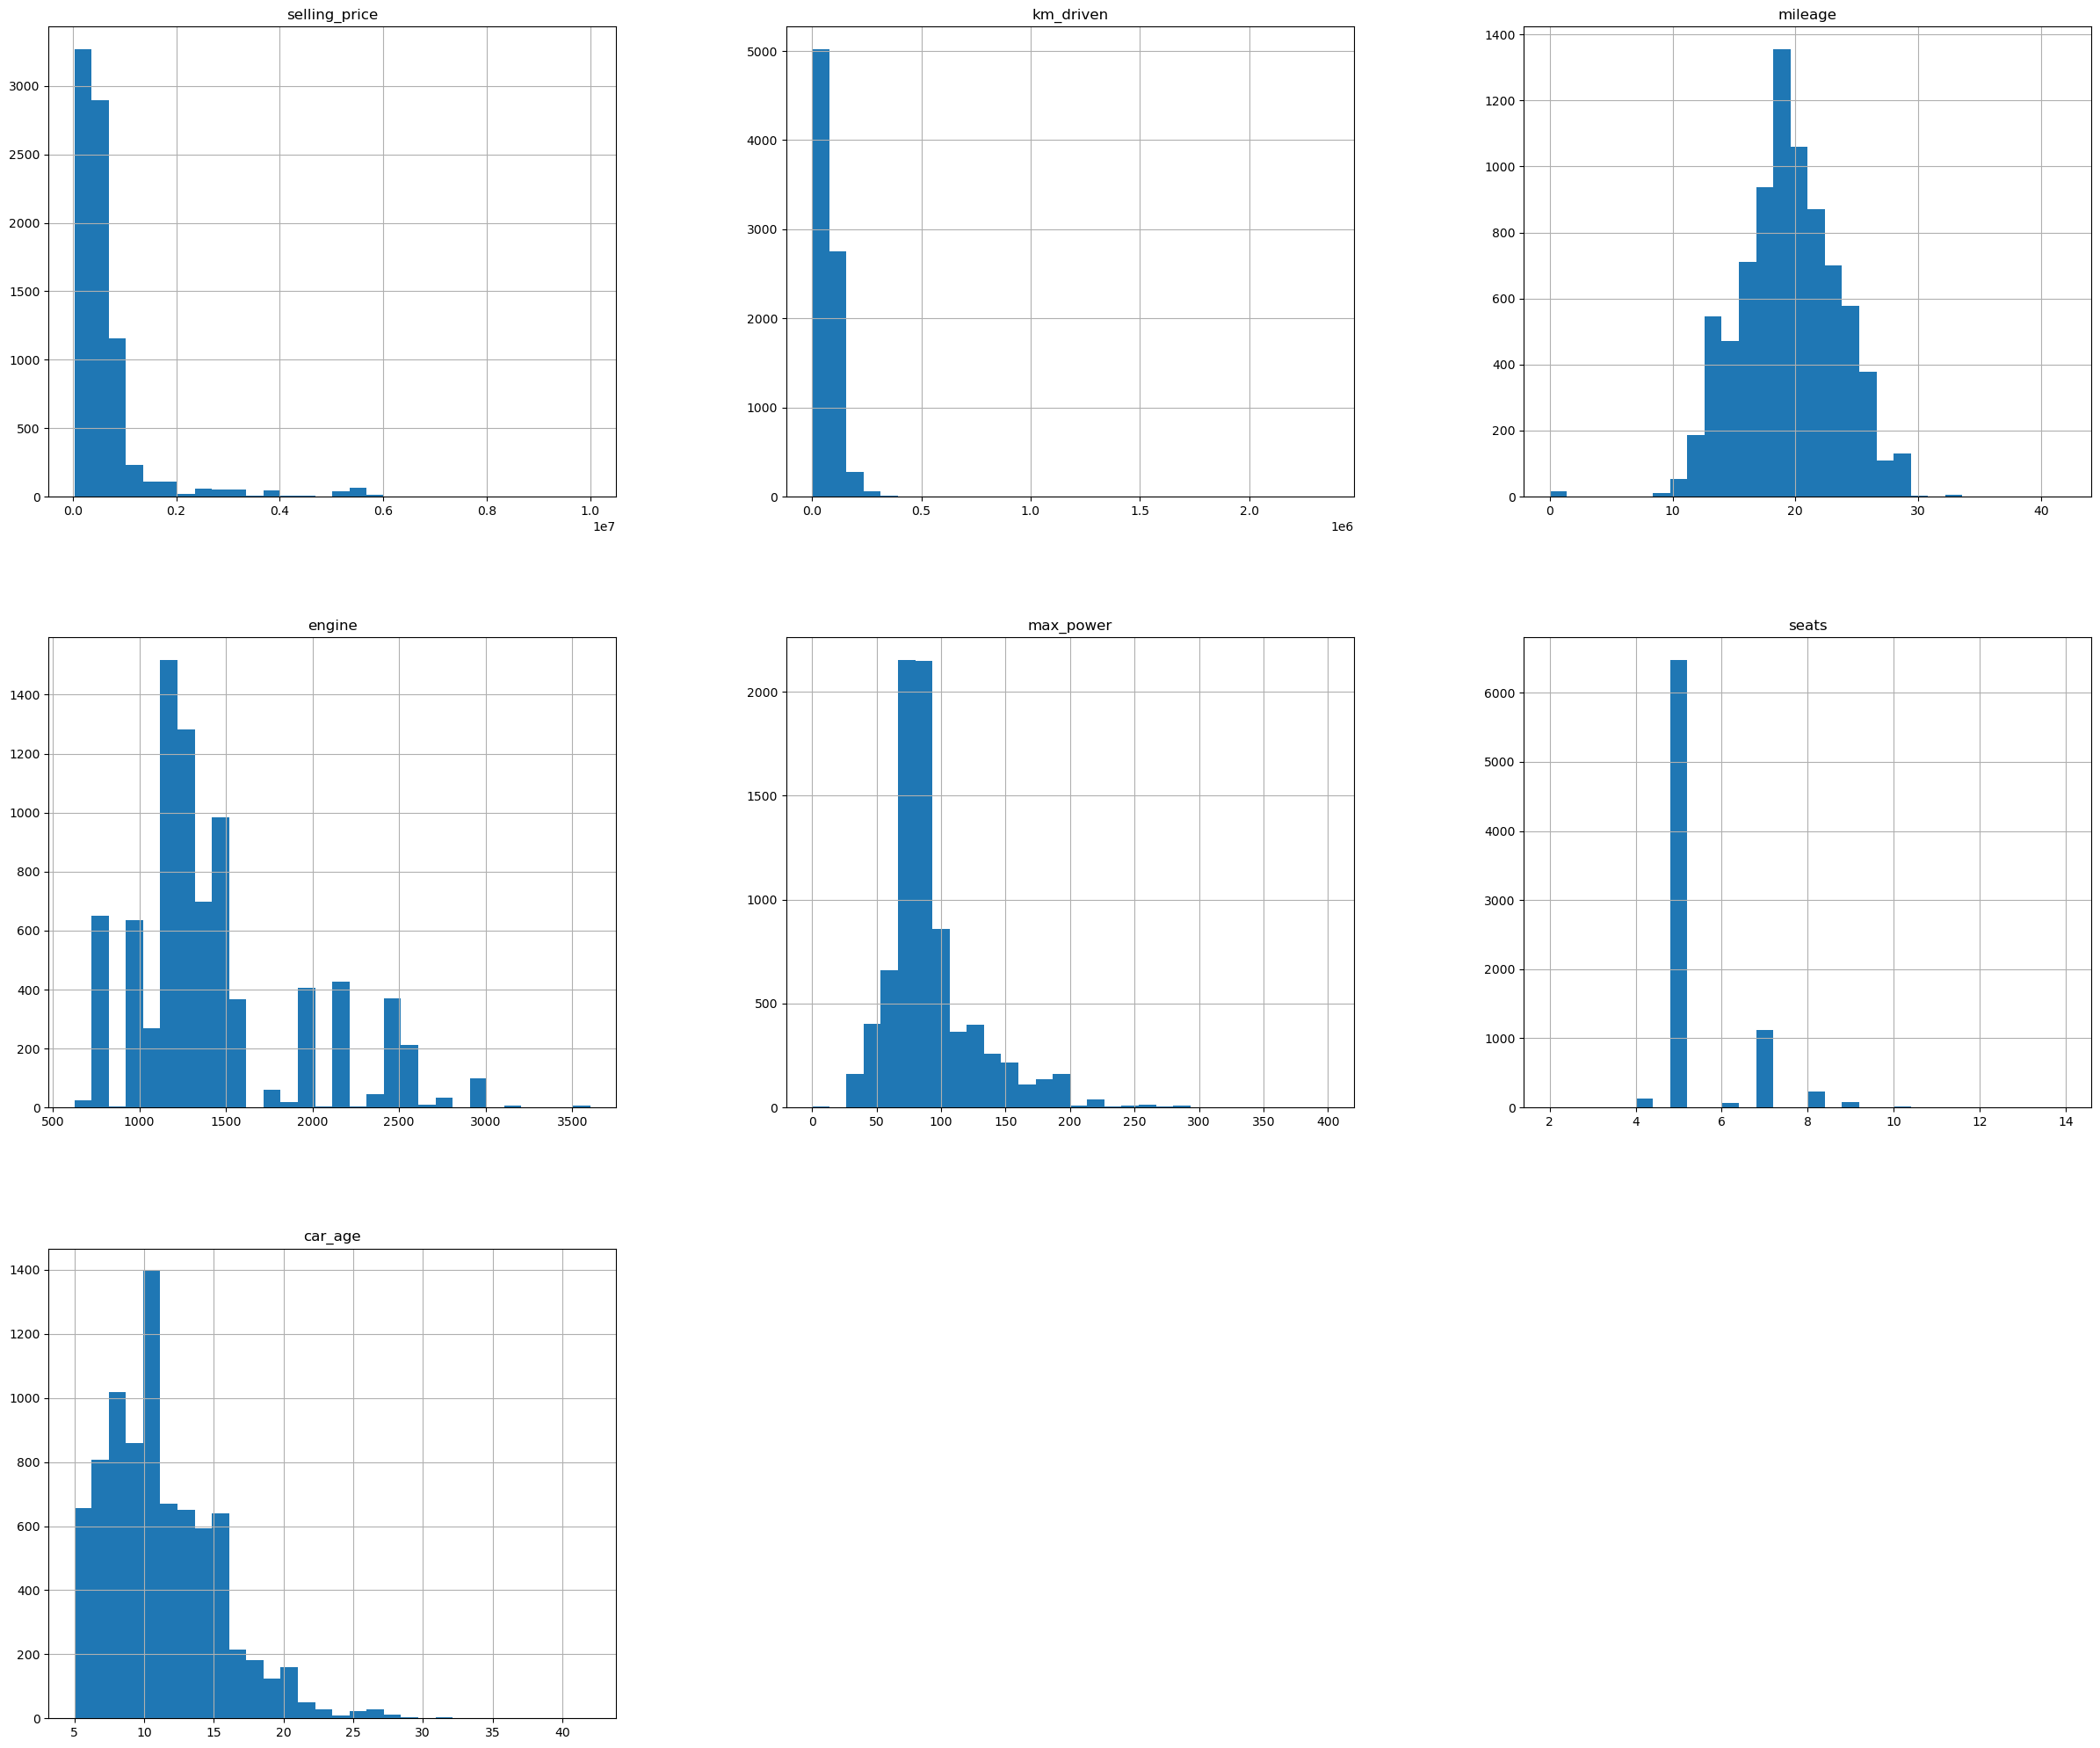

In [17]:
df.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

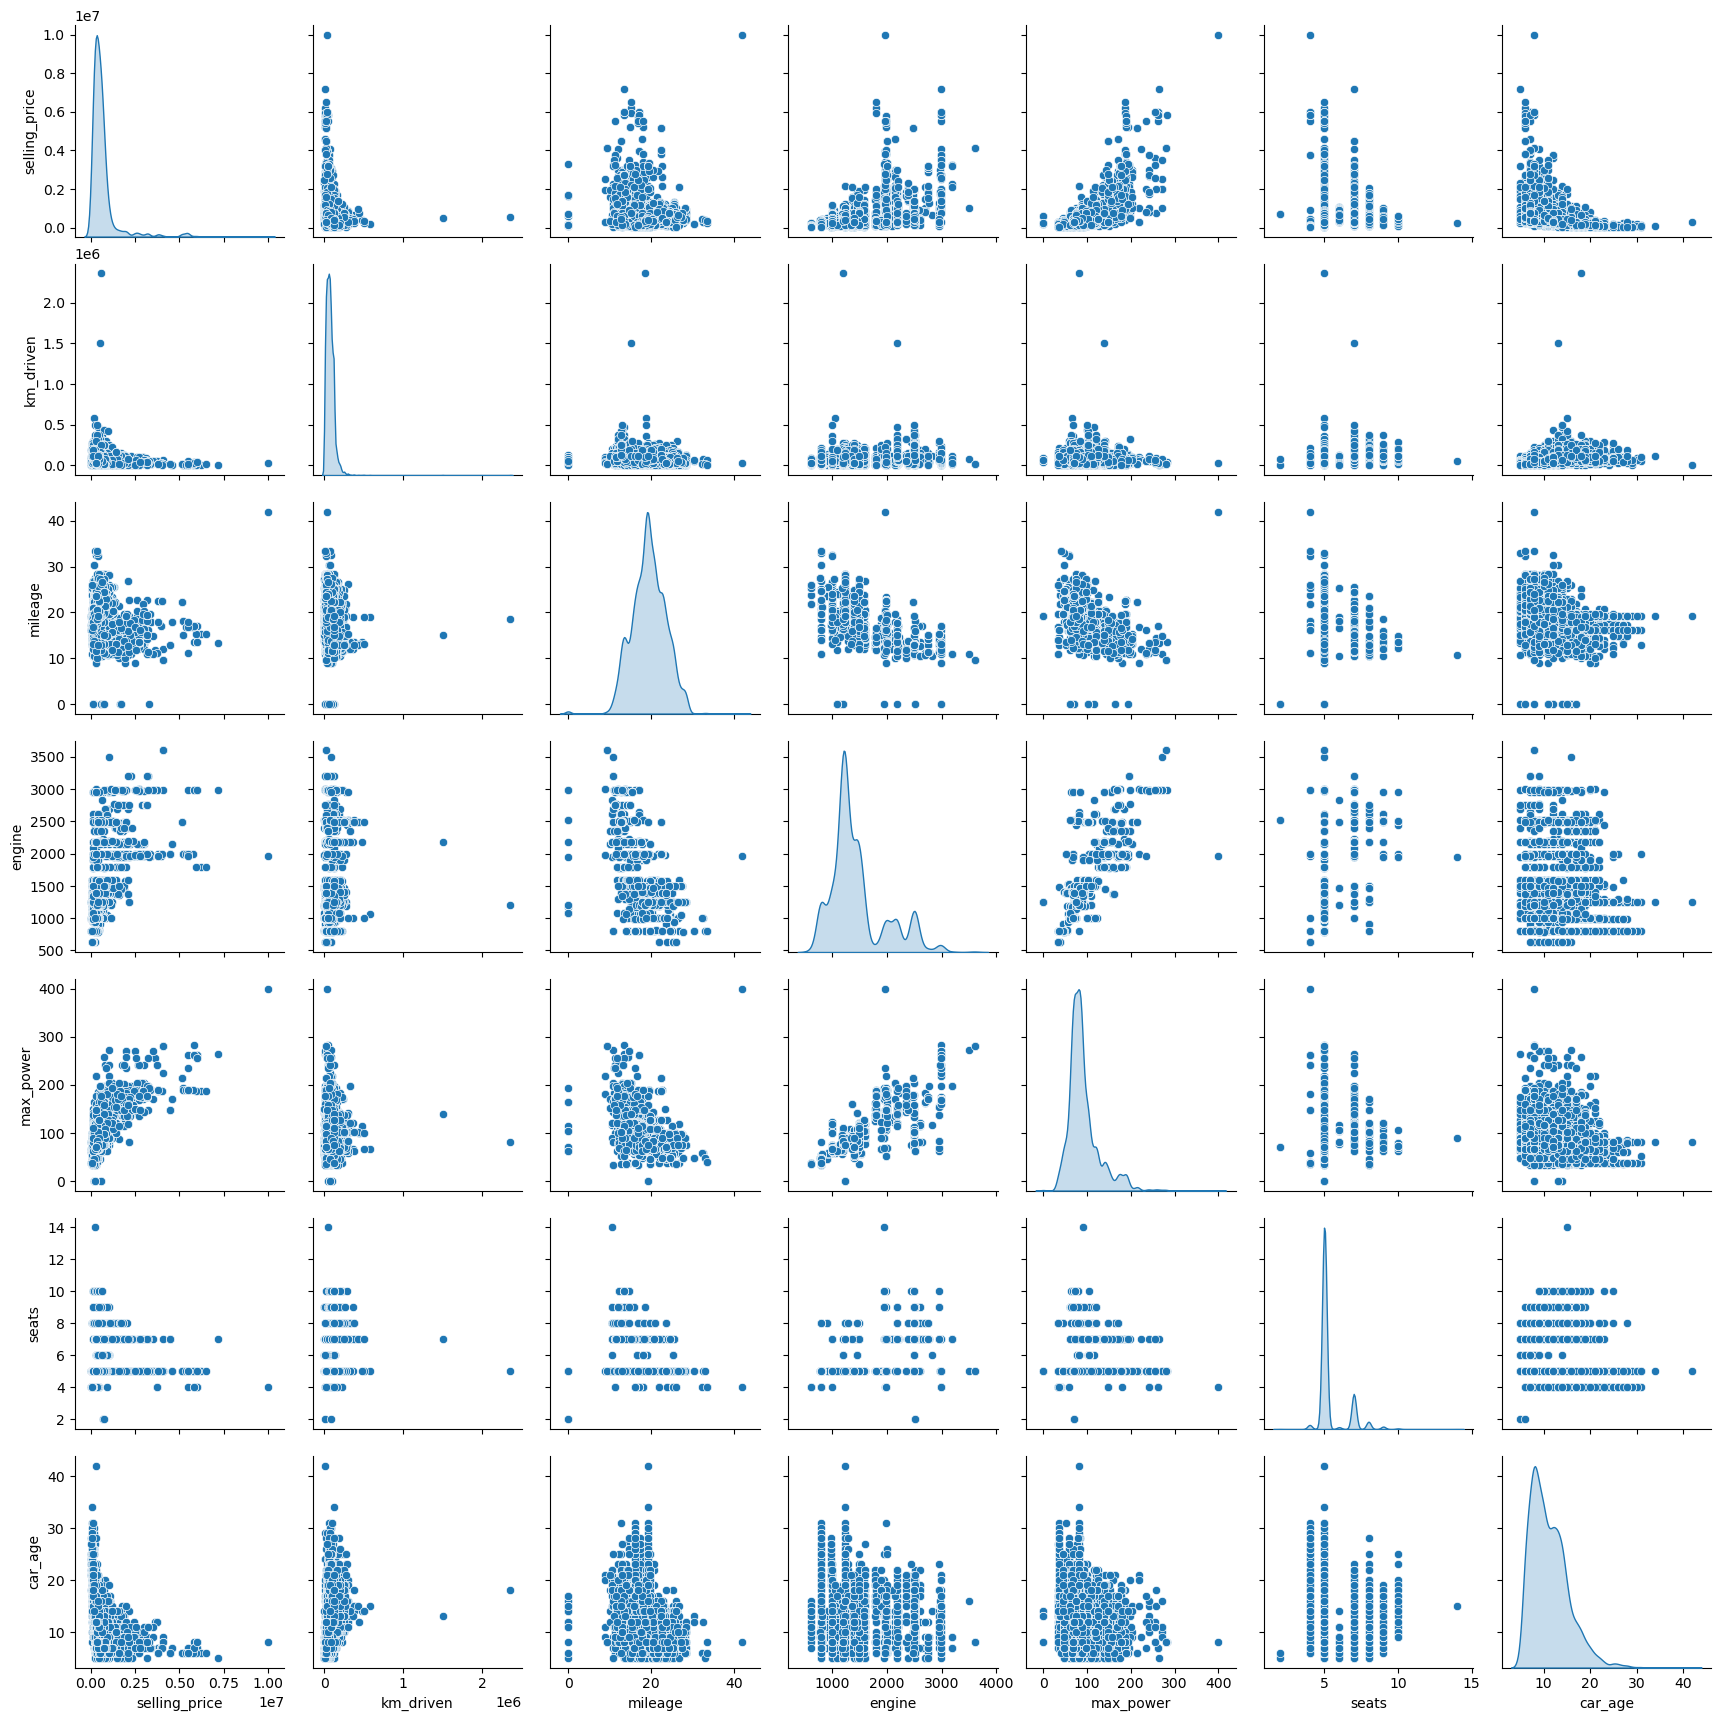

In [18]:
ax = sns.pairplot(df, diag_kind="kde")

### Single Variable Linear Regression

Start with max_power as a single variable regressor, as according to the correlation analysis it appears to be the stronger predictor

In [20]:
price = smf.ols(formula='max_power ~ selling_price', data=df).fit()
print(price.summary())

                            OLS Regression Results                            
Dep. Variable:              max_power   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                 1.032e+04
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:32:17   Log-Likelihood:                -37186.
No. Observations:                8128   AIC:                         7.438e+04
Df Residuals:                    8126   BIC:                         7.439e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        70.3185      0.332    211.659

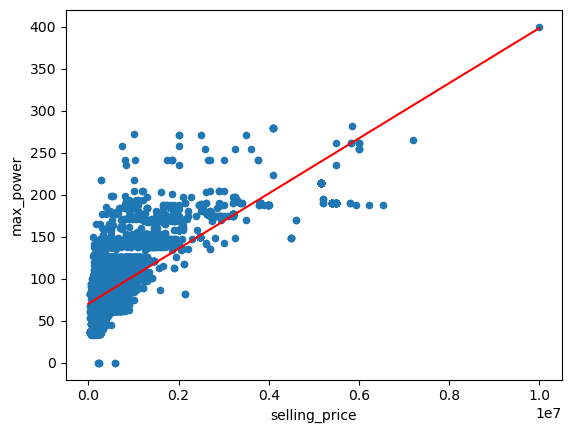

In [21]:
ax = df.plot(x='selling_price', y='max_power', kind='scatter')
p = price.params
x = np.arange(0, 10000000)
ax.plot(x, p.Intercept + p.selling_price * x, 'r-')
fig = plt.gcf()

### Multivariate Linear Regression

According to the single-variable model, there is a strong relationship between selling_price and max_power. However, the r-squared values could potentially be higher when considering multiple variables

In [53]:
allowed_factors = ['km_driven','mileage','engine','max_power','seats','car_age']

In [ ]:
# Split the dataset into training and testing datasets

price_train, price_test = train_test_split(df, test_size = 0.20, shuffle = True, random_state = 1)
print(price_train.shape)
print(price_test.shape)

(6502, 12)
(1626, 12)


### Forward stepwise selection

Determine best variables for multi-variate regression using foward stepwise selection method

In [ ]:
# First iteration (k=1)

best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='selling_price ~'+p, data=price_train).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

km_driven 0.06394438989843276
mileage 0.01603092464426481
engine 0.21270086960299173
max_power 0.5672837896610405
seats 0.0018071086038374817
car_age 0.17010294321901243
best: ['max_power', 0.5672837896610405]


In [69]:
price1 = smf.ols(formula='selling_price ~ max_power', data=df).fit()
print(price1.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                 1.032e+04
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:00:21   Log-Likelihood:            -1.1874e+05
No. Observations:                8128   AIC:                         2.375e+05
Df Residuals:                    8126   BIC:                         2.375e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.174e+05   1.64e+04    -55.852      0.0

In [ ]:
# Second iteration (k=2)

best = ['',0]
allowed_factors_new = allowed_factors[:]
allowed_factors_new.remove('max_power')
for p in allowed_factors_new:
    model  = smf.ols(formula='selling_price ~ max_power +'+p, data=price_train).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)


km_driven 0.6134196680279572
mileage 0.5942450137252879
engine 0.5762773144200589
seats 0.57793445163495
car_age 0.626753292853356
best: ['car_age', 0.626753292853356]


In [71]:
price2 = smf.ols(formula='selling_price ~ max_power + car_age', data=df).fit()
print(price2.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     6718.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:            -1.1811e+05
No. Observations:                8128   AIC:                         2.362e+05
Df Residuals:                    8125   BIC:                         2.362e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.18e+05   2.42e+04     -8.999      0.0

In [ ]:
# (k=3)

best = ['',0]
allowed_factors_new = allowed_factors[:]
allowed_factors_new.remove('max_power')
allowed_factors_new.remove('car_age')
for p in allowed_factors_new:
    model  = smf.ols(formula='selling_price ~ max_power + car_age +'+p, data=price_train).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

km_driven 0.6401232502550487
mileage 0.631109477757787
engine 0.6297471442248588
seats 0.635831408787387
best: ['km_driven', 0.6401232502550487]


In [73]:
price3 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven', data=df).fit()
print(price3.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     4667.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:00:24   Log-Likelihood:            -1.1800e+05
No. Observations:                8128   AIC:                         2.360e+05
Df Residuals:                    8124   BIC:                         2.360e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.269e+05   2.39e+04     -9.488      0.0

In [ ]:
# (k=4)

best = ['',0]
allowed_factors_new = allowed_factors[:]
allowed_factors_new.remove('max_power')
allowed_factors_new.remove('car_age')
allowed_factors_new.remove('km_driven')
for p in allowed_factors_new:
    model  = smf.ols(formula='selling_price ~ max_power + car_age + km_driven +'+p, data=price_train).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

mileage 0.6439846342900045
engine 0.6404736342718638
seats 0.6444902981089763
best: ['seats', 0.6444902981089763]


In [75]:
price4 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats', data=df).fit()
print(price4.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     3575.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:00:25   Log-Likelihood:            -1.1795e+05
No. Observations:                8128   AIC:                         2.359e+05
Df Residuals:                    8123   BIC:                         2.359e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.542e+04   3.74e+04      2.017      0.0

In [ ]:
# (k=5)

best = ['',0]
allowed_factors_new = allowed_factors[:]
allowed_factors_new.remove('max_power')
allowed_factors_new.remove('car_age')
allowed_factors_new.remove('km_driven')
allowed_factors_new.remove('seats')
for p in allowed_factors_new:
    model  = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats +'+p, data=price_train).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

mileage 0.6458143508699747
engine 0.645507641219479
best: ['mileage', 0.6458143508699747]


In [77]:
price5 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats + mileage', data=df).fit()
print(price5.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2872.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:00:26   Log-Likelihood:            -1.1794e+05
No. Observations:                8128   AIC:                         2.359e+05
Df Residuals:                    8122   BIC:                         2.359e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.371e+05   7.67e+04     -3.094      0.0

In [ ]:
# Only one variable left, so no need to find best (k=6)

price6 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats + mileage + engine', data=df).fit()
print(price6.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     2406.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:00:27   Log-Likelihood:            -1.1792e+05
No. Observations:                8128   AIC:                         2.359e+05
Df Residuals:                    8121   BIC:                         2.359e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.233e+05   7.66e+04     -2.917      0.0

### Compare adjusted r-squared values for training/testing datasets

In [ ]:
x = np.arange(1,7)
adjr2_train = [price1.rsquared_adj, price2.rsquared_adj, price3.rsquared_adj, price4.rsquared_adj, price5.rsquared_adj, price6.rsquared_adj]
test1 = smf.ols(formula='selling_price ~ max_power', data=price_test).fit()
test2 = smf.ols(formula='selling_price ~ max_power + car_age', data=price_test).fit()
test3 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven', data=price_test).fit()
test4 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats', data=price_test).fit()
test5 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats + mileage', data=price_test).fit()
test6 = smf.ols(formula='selling_price ~ max_power + car_age + km_driven + seats + mileage + engine', data=price_test).fit()

adjr2_test = [test1.rsquared_adj, test2.rsquared_adj, test3.rsquared_adj, test4.rsquared_adj, test5.rsquared_adj, test6.rsquared_adj]

[Text(0.5, 0, '# of Factors'), Text(0, 0.5, 'Adjusted R^2')]

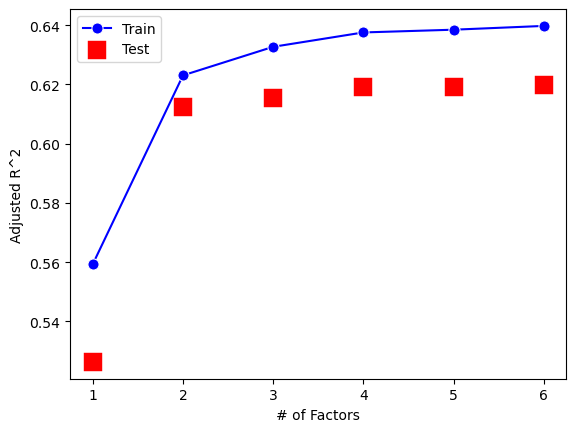

In [83]:
ax = sns.lineplot(x=x, y=adjr2_train, linestyle='-', marker='o', markersize=8, label='Train', color='blue')
sns.scatterplot(x=x, y=adjr2_test, marker='s', s=200, label='Test', color='red')
ax.set(xlabel='# of Factors', ylabel='Adjusted R^2')

In [84]:
# Final Model
price2 = smf.ols(formula='selling_price ~ max_power + car_age', data=df).fit()
print(price2.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     6718.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:04:16   Log-Likelihood:            -1.1811e+05
No. Observations:                8128   AIC:                         2.362e+05
Df Residuals:                    8125   BIC:                         2.362e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.18e+05   2.42e+04     -8.999      0.0

### Discussion

Final results show the optimal linear regression model for the data is 'selling_price ~ max_power + car_age'
- Makes intuitive sense, as the older a car is, the lower the resale value
- Did not expect max_power to have such a strong relationship to selling_price, but also makes sense due to the max_power of a vehicle being tied to overall vehicle performance

Other variables did not contribute meaningfully to the overal model effectiveness (K > 2)
- Limited increase in r-squared after max_power and car_age
- In practice, the simpler model (k=2) should yield more consistent results

### Conclusion

Based on the linear regression modeling, used car sellers should base their prices on a vehicles maximum engine power and the age of the car
- Cars with higher max power command a higher price
- Older cars should be priced lower